In [68]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [70]:
data_dir = 'data'

In [71]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear = 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [72]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [73]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset,  [train_size, val_size])

In [74]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [75]:
class FlowerClassifier(nn.Module):
    def __init__(self):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 5)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x)) 
        x = self.pool(x)
        x = self.relu(self.conv2(x)) 
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x)) 
        x = self.pool(x)
        x = x.view(-1, 128 * 9 * 9)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = FlowerClassifier().to(device)


In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_acc = []
val_acc = []
train_loss = []
val_loss = []

In [77]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    if(epoch + 1) % 10 == 0:
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit = 'batch')

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


        avg_loss = running_loss / (len(train_loader))
        avg_accuracy = 100 * correct / total
        train_loader_tqdm.set_postfix(loss=avg_loss, accuracy=avg_accuracy)

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(100 * correct / total)

    if(epoch + 1) % 10 ==0:
        model.eval()
        val_loss_epoch = 0.0
        val_correct = 0
        val_total = 0

        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit='batch')

        with torch.no_grad():
            for images, labels in val_loader_tqdm:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_epoch += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct +=(predicted == labels).sum().item()

                avg_val_loss = val_loss_epoch / len(val_loader)
                avg_val_accuracy = 100 * val_correct /val_total
                val_loader_tqdm.set_postfix(val_loss=avg_val_loss, val_accuracy=avg_val_accuracy)


        val_loss.append(val_loss_epoch / len(val_loader))
        val_acc.append(100 * val_correct / val_total)

        print(f'Epoch {epoch+1}/{num_epochs}, '
            f'Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, '
            f'Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%')

Epoch 10/100 - Validation: 100%|██████████| 27/27 [00:02<00:00, 11.41batch/s, val_accuracy=74.2, val_loss=0.687]


Epoch 10/100, Train Loss: 0.7178, Train Acc: 72.86%, Val Loss: 0.6872, Val Acc: 74.19%


Epoch 20/100 - Validation: 100%|██████████| 27/27 [00:02<00:00, 11.63batch/s, val_accuracy=77.9, val_loss=0.62] 


Epoch 20/100, Train Loss: 0.5059, Train Acc: 81.03%, Val Loss: 0.6198, Val Acc: 77.89%


Epoch 30/100 - Validation: 100%|██████████| 27/27 [00:02<00:00, 11.55batch/s, val_accuracy=80.1, val_loss=0.615]


Epoch 30/100, Train Loss: 0.3757, Train Acc: 85.35%, Val Loss: 0.6148, Val Acc: 80.09%


Epoch 40/100 - Validation: 100%|██████████| 27/27 [00:02<00:00, 11.14batch/s, val_accuracy=78.1, val_loss=0.716]


Epoch 40/100, Train Loss: 0.3078, Train Acc: 89.60%, Val Loss: 0.7159, Val Acc: 78.12%


Epoch 50/100 - Validation: 100%|██████████| 27/27 [00:02<00:00, 11.25batch/s, val_accuracy=80.4, val_loss=0.631]


Epoch 50/100, Train Loss: 0.2478, Train Acc: 91.43%, Val Loss: 0.6311, Val Acc: 80.44%


Epoch 60/100 - Validation: 100%|██████████| 27/27 [00:02<00:00, 11.81batch/s, val_accuracy=78.5, val_loss=0.697]


Epoch 60/100, Train Loss: 0.2166, Train Acc: 92.41%, Val Loss: 0.6967, Val Acc: 78.47%


Epoch 70/100 - Validation: 100%|██████████| 27/27 [00:02<00:00, 11.49batch/s, val_accuracy=82.4, val_loss=0.704]


Epoch 70/100, Train Loss: 0.1917, Train Acc: 93.63%, Val Loss: 0.7041, Val Acc: 82.41%


Epoch 80/100 - Validation: 100%|██████████| 27/27 [00:02<00:00, 11.74batch/s, val_accuracy=82.4, val_loss=0.815]


Epoch 80/100, Train Loss: 0.1326, Train Acc: 95.48%, Val Loss: 0.8151, Val Acc: 82.41%


Epoch 90/100 - Validation: 100%|██████████| 27/27 [00:02<00:00, 11.17batch/s, val_accuracy=80.8, val_loss=0.87] 


Epoch 90/100, Train Loss: 0.1475, Train Acc: 94.82%, Val Loss: 0.8698, Val Acc: 80.79%


Epoch 100/100 - Validation: 100%|██████████| 27/27 [00:02<00:00, 11.45batch/s, val_accuracy=80.8, val_loss=0.848]

Epoch 100/100, Train Loss: 0.1732, Train Acc: 94.03%, Val Loss: 0.8482, Val Acc: 80.79%


In [78]:
torch.save(model.state_dict(), 'flower_model.pth')

In [82]:
torch.save(model, 'flower_model_full.pth')

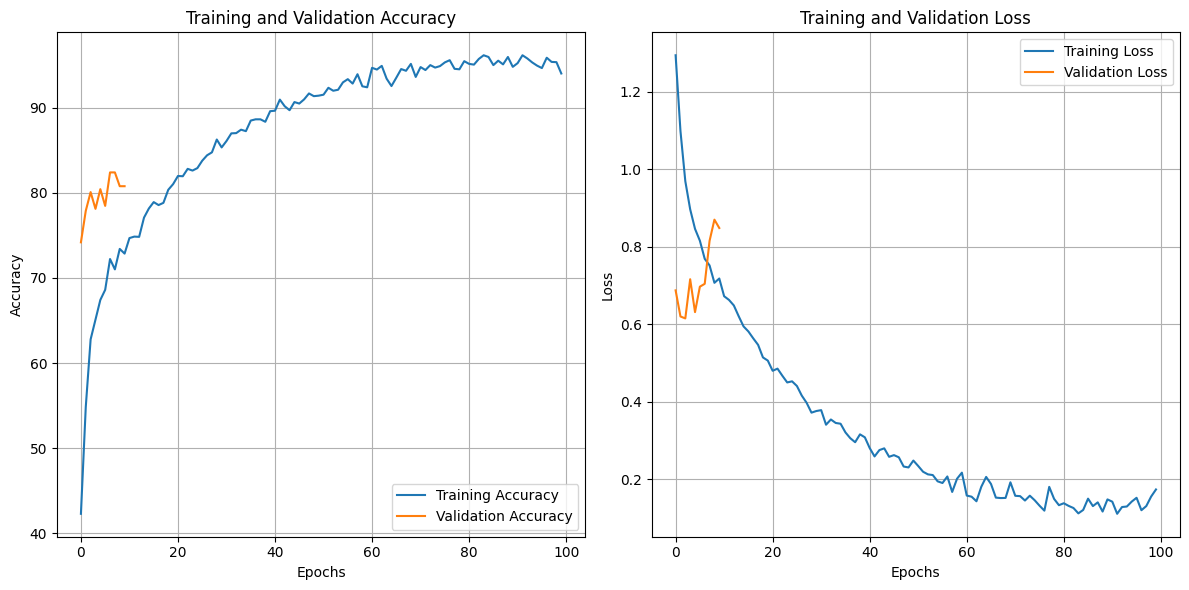

In [81]:

epochs_range = range(num_epochs + 1)

plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range[:len(train_acc)], train_acc, label='Training Accuracy')
plt.plot(epochs_range[:len(val_acc)], val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range[:len(train_loss)], train_loss, label='Training Loss')
plt.plot(epochs_range[:len(val_loss)], val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()
